# Imports and settings

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from collections import deque
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization, Flatten, Bidirectional
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [0]:
#in frames
SEQ_LEN = 100
EPOCHS = 300
LEARNING_RATE = 0.01
BATCH_SIZE = 512
LOSS =  tf.keras.losses.mse#tf.keras.losses.logcosh
LOSS_NAME = "MSE"
OPT =  tf.keras.optimizers.Adam(lr=LEARNING_RATE, decay=1e-6)
NAME = f"RacingLine-{SEQ_LEN}-EPOCH-{EPOCHS}-LR-{LEARNING_RATE}-BS-{BATCH_SIZE}-LOSS-{LOSS_NAME}"

MAX_X = 15.29
MIN_X = -225.62
MAX_Y = 77.88
MIN_Y = -275.18

# Preprocessing functions

In [0]:
def sk_scale_df(_df):
    for col in _df.columns:
        _df[col] = preprocessing.scale(_df[col].values)#scales values between 0 and 1

    _df.dropna(inplace=True)

    return _df

def min_max_scaling(_df):
    #x1 = (x - min_x) / (max_x - min_x)
    for col in _df.columns:
        max_val = max(_df[col])
        min_val = min(_df[col])

        _df[col] = (_df[col] - min_val) / (max_val - min_val)

    _df.dropna(inplace=True)

    return _df

def build_seq(_df):
    #shape:
    #input
    #(legth data set, SEQ_LEN, 5)
    #output
    #(length df, SEQ_LEN, 2)

    out_df = _df.copy()

    out_df = out_df.drop(["birdVelocity", "pipeY"], axis=1)#drops all the non x and y columns

    sequential_data = []
    for i in range(len(_df.values) - (SEQ_LEN + SEQ_LEN)):

        prev_end = i+SEQ_LEN;

        _inp = _df.values[i:prev_end]
        _out = out_df.values[prev_end:prev_end+SEQ_LEN]
        
        sequential_data.append([np.array(_inp), np.array(_out)])

    random.shuffle(sequential_data)

    X = []
    y = []

    for seq, target in sequential_data:
        X.append(seq)
        y.append(target)

    return np.array(X), np.array(y)

# load and preprocess data

In [23]:
from google.colab import files
uploaded = files.upload()

import io
main_df = pd.read_csv(io.BytesIO(uploaded['flappyBird.csv']))

main_df = sk_scale_df(main_df)

x_vals = np.linspace(start=0, stop=len(main_df), num=len(main_df))

#y vals are inverted as p5 has the origin in the top left corner
main_input, main_output = build_seq(main_df)

train_input, test_input, train_output, test_output = train_test_split(main_input, main_output, test_size = 0.1, random_state = 0)

Saving flappyBird.csv to flappyBird (6).csv


# Train model

In [25]:
model = Sequential()

model.add(LSTM(128, input_shape=(train_input.shape[1:]), return_sequences=True, activation="tanh"))
model.add(Dropout(0.2))

model.add(LSTM(128, return_sequences=True, activation="tanh"))
model.add(Dropout(0.2))

model.add(LSTM(128, return_sequences=True, activation="tanh"))

model.add(Dense(2,  activation='linear'))

model.compile(loss=LOSS, 
                optimizer=OPT)

# Train model
history = model.fit(
    train_input, train_output,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(test_input, test_output)
)

pred = model.predict(np.array([test_input[0]]))

Train on 1581 samples, validate on 176 samples
Epoch 1/300
1581/1581 [==============================] - 2s 1ms/sample - loss: 0.5189 - val_loss: 0.3610
Epoch 2/300
1581/1581 [==============================] - 1s 342us/sample - loss: 0.3863 - val_loss: 0.3262
Epoch 3/300
1581/1581 [==============================] - 1s 324us/sample - loss: 0.3460 - val_loss: 0.4475
Epoch 4/300
1581/1581 [==============================] - 1s 327us/sample - loss: 0.3646 - val_loss: 0.2980
Epoch 5/300
1581/1581 [==============================] - 1s 325us/sample - loss: 0.3366 - val_loss: 0.3182
Epoch 6/300
1581/1581 [==============================] - 1s 323us/sample - loss: 0.3650 - val_loss: 0.2809
Epoch 7/300
1581/1581 [==============================] - 1s 322us/sample - loss: 0.3458 - val_loss: 0.2984
Epoch 8/300
1581/1581 [==============================] - 1s 326us/sample - loss: 0.3286 - val_loss: 0.2840
Epoch 9/300
1581/1581 [==============================] - 1s 321us/sample - loss: 0.3173 - val_loss:

# Plot predicition

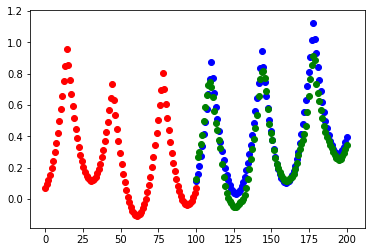

In [26]:
x_in_seq_vals = np.linspace(start=0, stop=SEQ_LEN, num=SEQ_LEN)
x_out_seq_vals = np.linspace(start=SEQ_LEN, stop=2*SEQ_LEN, num=SEQ_LEN)

y_inp = []
y_out = []
y_pred = []


for i in range(SEQ_LEN):
    y_inp.append(test_input[0][i][0])
    y_out.append(test_output[0][i][0])
    y_pred.append(pred[0][i][0])

plt.scatter(x_in_seq_vals, y_inp, color="red", label="input")
plt.scatter(x_out_seq_vals, y_out, color="blue", label="output")
plt.scatter(x_out_seq_vals, y_pred, color="green", label="output")

#plt.scatter(x_vals, main_df["birdY"], color="green")
#plt.scatter(x_vals, main_df["pipeY"], color="black")

plt.show()

# Save model

In [27]:
model.save('keras.h5')
!pip install tensorflowjs 
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/
!zip -r model.zip model 
from google.colab import files
files.download('model.zip')

mkdir: cannot create directory ‘model’: File exists
updating: model/ (stored 0%)
updating: model/group1-shard1of1.bin (deflated 7%)
updating: model/model.json (deflated 82%)
